In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

In [2]:
auctions = DataFetcher()
auctions.fetch_auction_data()
data = auctions.auction_data

In [3]:
usts = USTs(auction_data=data, price_data=None, curve_data=None)
otr = usts.get_nth_OTRs(10)
otr

,cusip,auction_date,security_term,avg_med_yield,maturity_date,run
0,91282CNE7,2025-05-27,2-Year,3.900,2027-05-31,1
1,91282CMX6,2025-04-23,2-Year,NaN,2027-04-30,2
2,91282CMY4,2025-04-22,2-Year,3.740,2027-04-30,3
3,91282CMV0,2025-03-25,2-Year,3.936,2027-03-31,4
4,91282CMP3,2025-02-24,2-Year,4.130,2027-02-28,5
...,...,...,...,...,...,...
65,912810UA4,2024-05-09,30-Year,4.585,2054-05-15,6
66,912810TY4,2024-02-22,30-Year,2.107,2054-02-15,7
67,912810TX6,2024-02-08,30-Year,4.314,2054-02-15,8
68,912810TV0,2023-11-09,30-Year,4.650,2053-11-15,9


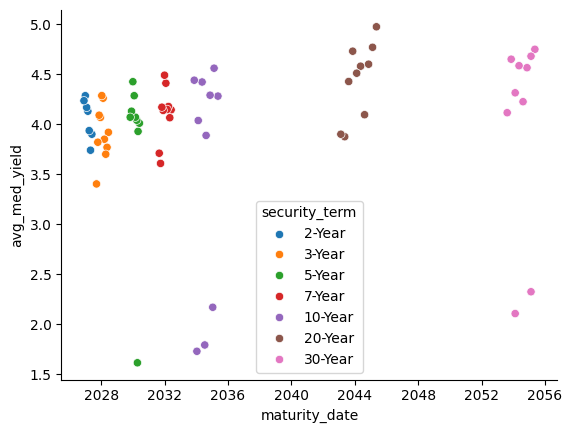

In [5]:
plt.Figure(figsize=(30,10))
sns.scatterplot(data=otr, x='maturity_date', y='avg_med_yield', hue='security_term')
sns.despine()

In [2]:
prices = DataFetcher().fetch_historical_UST_data(date="2025-06-17")


In [3]:
prices

,CUSIP,SECURITY TYPE,RATE,MATURITY DATE,CALL DATE,BUY,SELL,END OF DAY
0,912797NV5,MARKET BASED BILL,0.000%,06/20/2025,,0.000000,99.964750,0.000000
1,912797PT8,MARKET BASED BILL,0.000%,06/24/2025,,99.919500,99.919111,0.000000
2,912797NW3,MARKET BASED BILL,0.000%,06/26/2025,,99.896500,99.896000,0.000000
3,912797PU5,MARKET BASED BILL,0.000%,07/01/2025,,99.838417,99.837833,0.000000
4,912797NX1,MARKET BASED BILL,0.000%,07/03/2025,,99.815556,99.815111,0.000000
...,...,...,...,...,...,...,...,...
453,91282CKM2,MARKET BASED FRN,4.497%,04/30/2026,,100.063279,100.037539,0.000000
454,91282CLA7,MARKET BASED FRN,4.529%,07/31/2026,,100.095285,100.076009,0.000000
455,91282CLT6,MARKET BASED FRN,4.553%,10/31/2026,,100.137565,100.114073,0.000000
456,91282CMJ7,MARKET BASED FRN,4.444%,01/31/2027,,99.981891,99.942419,0.000000
